In [479]:
import fiona
import numpy as np
import pandas as pd
from rendering import *

%load_ext autoreload
%autoreload 2

set_up()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [480]:
filename = 'qgis_assets/modulos_automatico_final_new_foo.shp'
shp = fiona.open(filename)

In [481]:
# Plot rectangles with matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def plot_panels(shp, color_code, draw_text=False, text=None, draw_legend=True, savefig=None):
    fig, ax = plt.subplots()
    max_x = centroid_table_pd['x'].max() + 2
    min_x = centroid_table_pd['x'].min() - 2
    max_y = centroid_table_pd['y'].max() + 2
    min_y = centroid_table_pd['y'].min() - 2
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    width = 10 * (max_x - min_x) / (max_y - min_y)
    if draw_legend:
        width += 1
    fig.set_size_inches(width, 10)

    # Generate color palette from indices
    palette = np.array(sns.color_palette("hls", len(np.unique(color_code))))

    for (idx, elem) in enumerate(shp):
        x = []
        y = []
        for coord in elem['geometry']['coordinates'][0]:
            x.append(coord[0])
            y.append(coord[1])
        if color_code is None:
            ax.plot(x, y, color='black')
        else:
            ax.plot(x, y, color=palette[color_code[idx]], linewidth=1.5)

    if color_code is not None:
        # Show legend
        for i in range(len(np.unique(color_code))):
            ax.plot([], [], color=palette[i], label=i)
        if draw_legend:
            ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    if draw_text:
        for label in np.unique(color_code):
            random_idx = np.random.choice(np.where(color_code == label)[0])
            centroid = centroid_table[random_idx]
            text_label = label if text is None else text[random_idx]
            ax.text(centroid[0], centroid[1], text_label, fontsize=12, color='white', weight='bold', ha='center', va='center', bbox=dict(facecolor='black', edgecolor='none', alpha=0.8))

    plt.axis('off')
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig, dpi=500, transparent=True)
    plt.show()

In [482]:
centroid_table = []

for (idx, elem) in enumerate(shp):
    # Calculate centroid
    centroid = [0, 0]
    for coord in elem['geometry']['coordinates'][0]:
        centroid[0] += coord[0]
        centroid[1] += coord[1]
    centroid[0] /= len(elem['geometry']['coordinates'][0])
    centroid[1] /= len(elem['geometry']['coordinates'][0])

    centroid_table.append([centroid[0], centroid[1]])

centroid_table_pd = pd.DataFrame(centroid_table, columns=['x', 'y'])

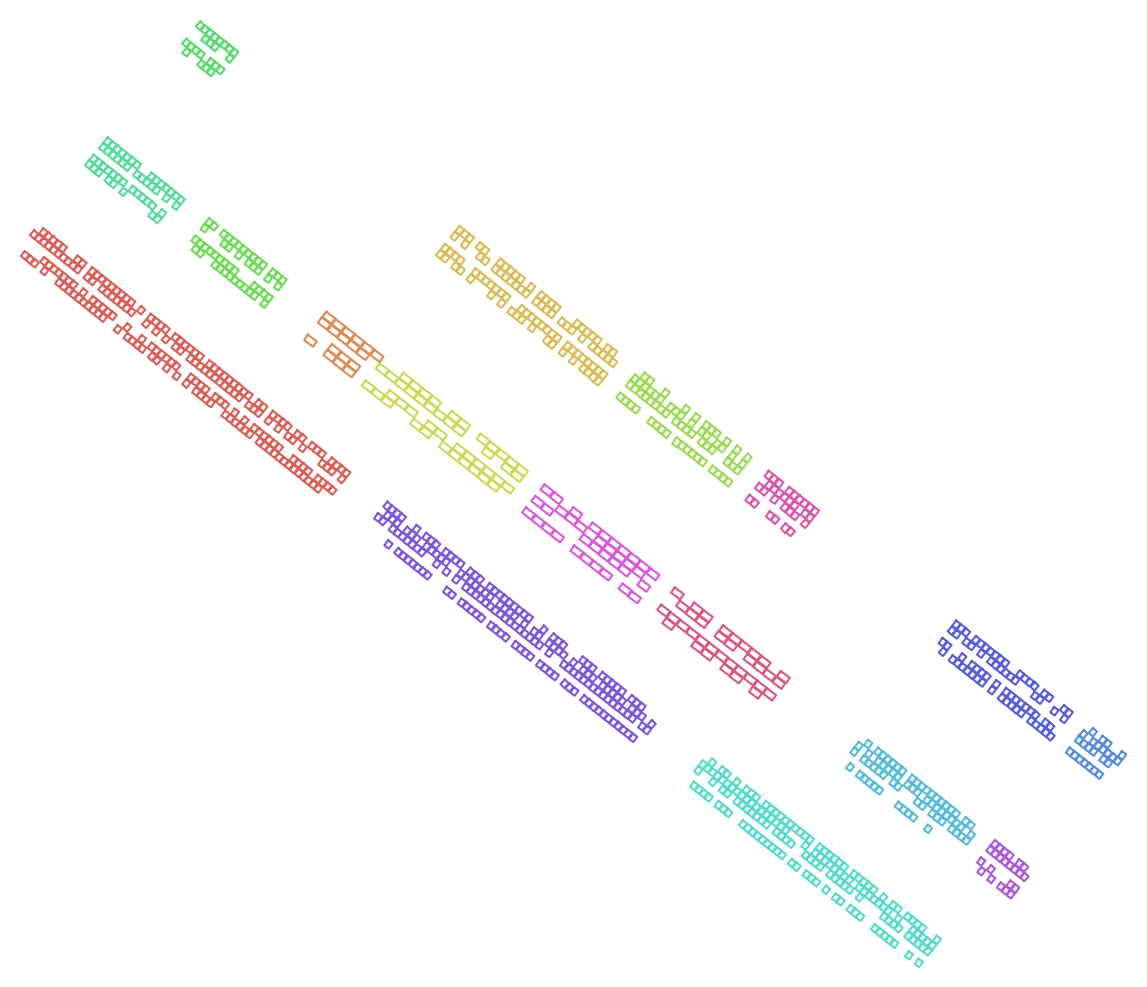

In [483]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=3, min_samples=5).fit(centroid_table_pd)
labels = db.labels_

plot_panels(shp, labels, draw_text=False, savefig='results/dbscan.png', draw_legend=False)

In [484]:
# Calculate average edge vector from each cell
average_direction = np.zeros(2)
for (idx, elem) in enumerate(shp):
    average_direction = average_direction + np.asarray([elem['geometry']['coordinates'][0][1][0] - elem['geometry']['coordinates'][0][0][0],
                elem['geometry']['coordinates'][0][1][1] - elem['geometry']['coordinates'][0][0][1]])
    # average_direction = average_direction + np.asarray([elem['geometry']['coordinates'][0][3][0] - elem['geometry']['coordinates'][0][0][0],
    #             elem['geometry']['coordinates'][0][3][1] - elem['geometry']['coordinates'][0][0][1]])

average_direction = average_direction / len(shp)

# Normalize both vectors
module = (average_direction[0] ** 2 + average_direction[1] ** 2) ** 0.5
norm_x = average_direction / module

In [485]:
print(norm_x)

[ 0.78677704 -0.6172373 ]


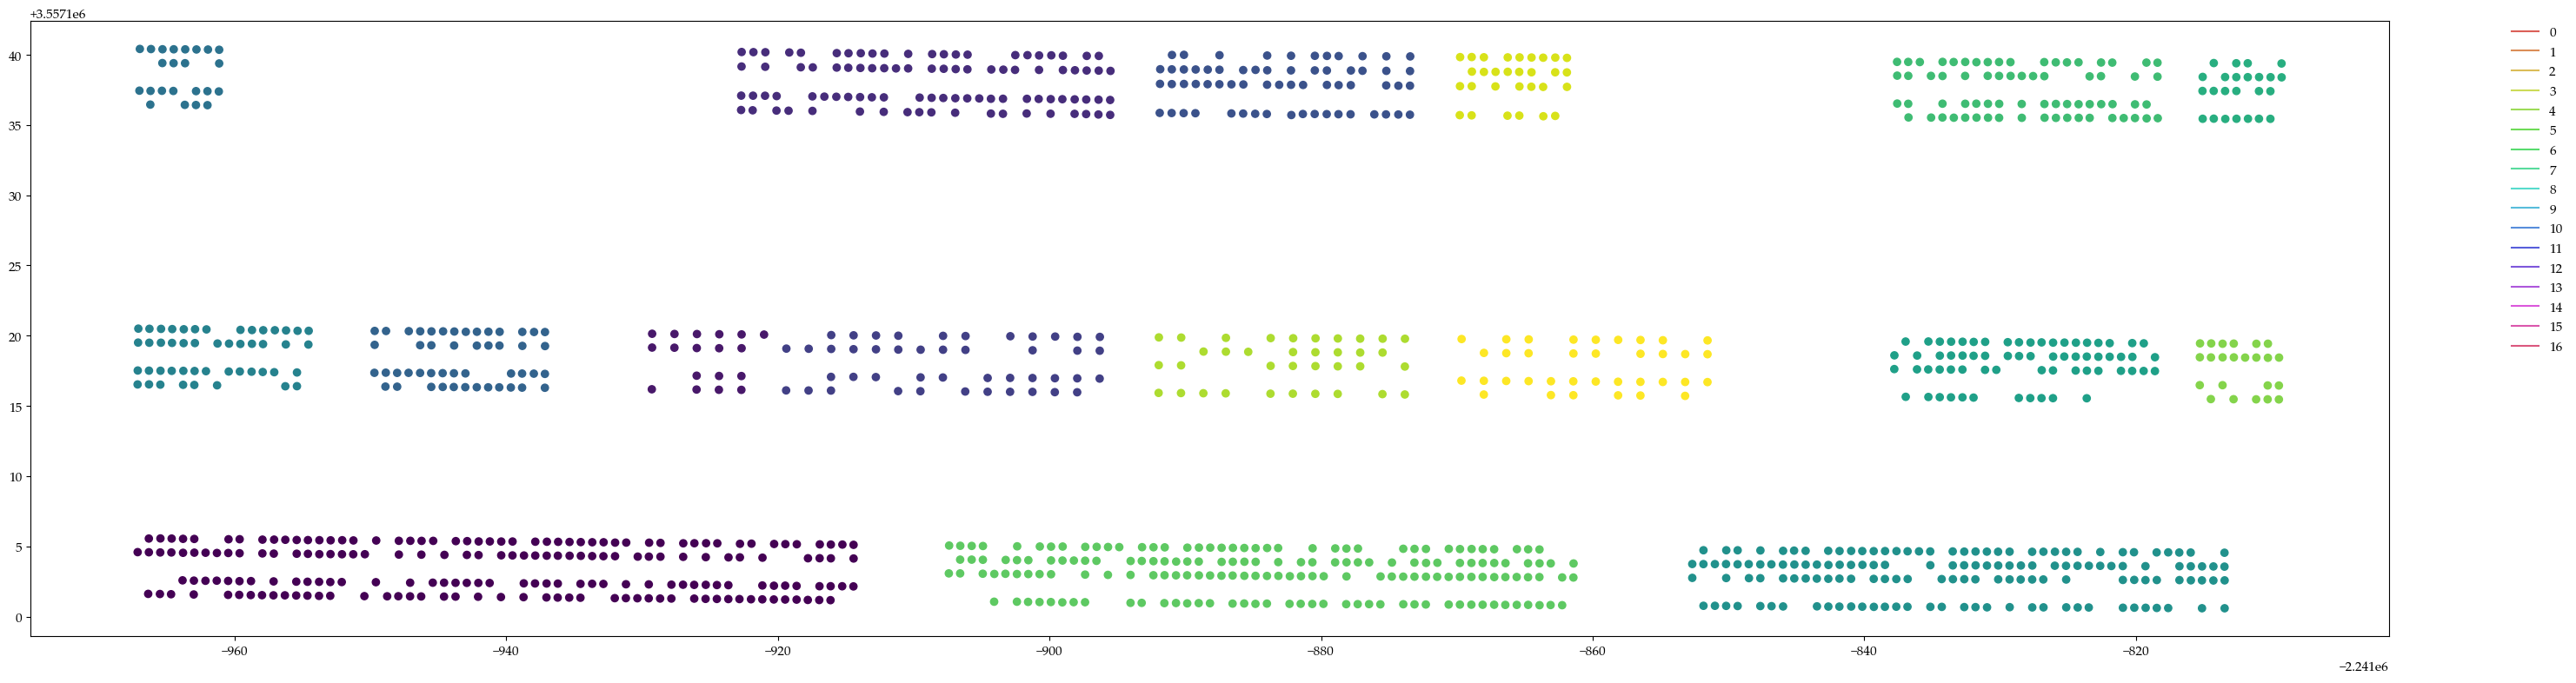

In [486]:
# Rotate points to align with x axis
rotated_centroid_table = []

for (idx, elem) in enumerate(shp):
    rotated_centroid_table.append([centroid_table[idx][0] * norm_x[0] + centroid_table[idx][1] * norm_x[1],
                                   -centroid_table[idx][0] * norm_x[1] + centroid_table[idx][1] * norm_x[0]])

rotated_centroid_table_pd = pd.DataFrame(rotated_centroid_table, columns=['x', 'y'])
plot_centroids(rotated_centroid_table_pd, labels, draw_text=False, savefig='results/dbscan_rotated.png')

In [487]:
cluster_centroid = np.zeros((len(np.unique(labels)), 2))

for cluster in np.unique(labels):
    centroids = rotated_centroid_table_pd[labels == cluster]
    # Calculate average centroid
    for centroid in centroids.values:
        cluster_centroid[cluster] += centroid
    cluster_centroid[cluster] /= len(centroids)

cluster_centroid = cluster_centroid.tolist()

In [488]:
def determine_row_col(centroids, max_vertical_distance=1.5):
    row_cluster = np.zeros(len(centroids))
    for (idx, elem) in enumerate(centroids):
        row_cluster[idx] = -1

    row = 1
    row_cluster[0] = 0

    # Determine different rows (not ordered yet)
    for (idx1, centroid) in enumerate(centroids):
        if idx1 > 0:
            min_vertical_distance = 100000
            for (idx2, centroid2) in enumerate(centroids):
                if idx1 != idx2 and row_cluster[idx2] != -1:
                    vertical_distance = abs(centroid[1] - centroid2[1])
                    if vertical_distance < min_vertical_distance and vertical_distance < max_vertical_distance:
                        min_vertical_distance = vertical_distance
                        row_cluster[idx1] = row_cluster[idx2]

            if min_vertical_distance == 100000:
                row_cluster[idx1] = row
                row += 1

    # Order rows in the x-axis
    new_labels = None
    for row_idx in range(row):
        cluster_indices = np.where(row_cluster == row_idx)[0]
        # Order cluster indices by x coordinate
        cluster_indices = [i for i in sorted(cluster_indices, key=lambda item: centroids[item][0])]

        if new_labels is None:
            new_labels = [cluster_indices]
        else:
            new_labels.append(cluster_indices)

    # Calculate aggregated centroid per row
    aggregated_centroid = np.zeros((len(new_labels), 2))
    for (idx1, cluster_indices) in enumerate(new_labels):
        for idx2 in cluster_indices:
            aggregated_centroid[idx1] += centroids[idx2]
        aggregated_centroid[idx1] /= len(cluster_indices)

    # Order in the y-axis
    new_label_order = [i[1] for i in sorted(enumerate(new_labels), key=lambda item: aggregated_centroid[item[0]][1])]

    return new_label_order

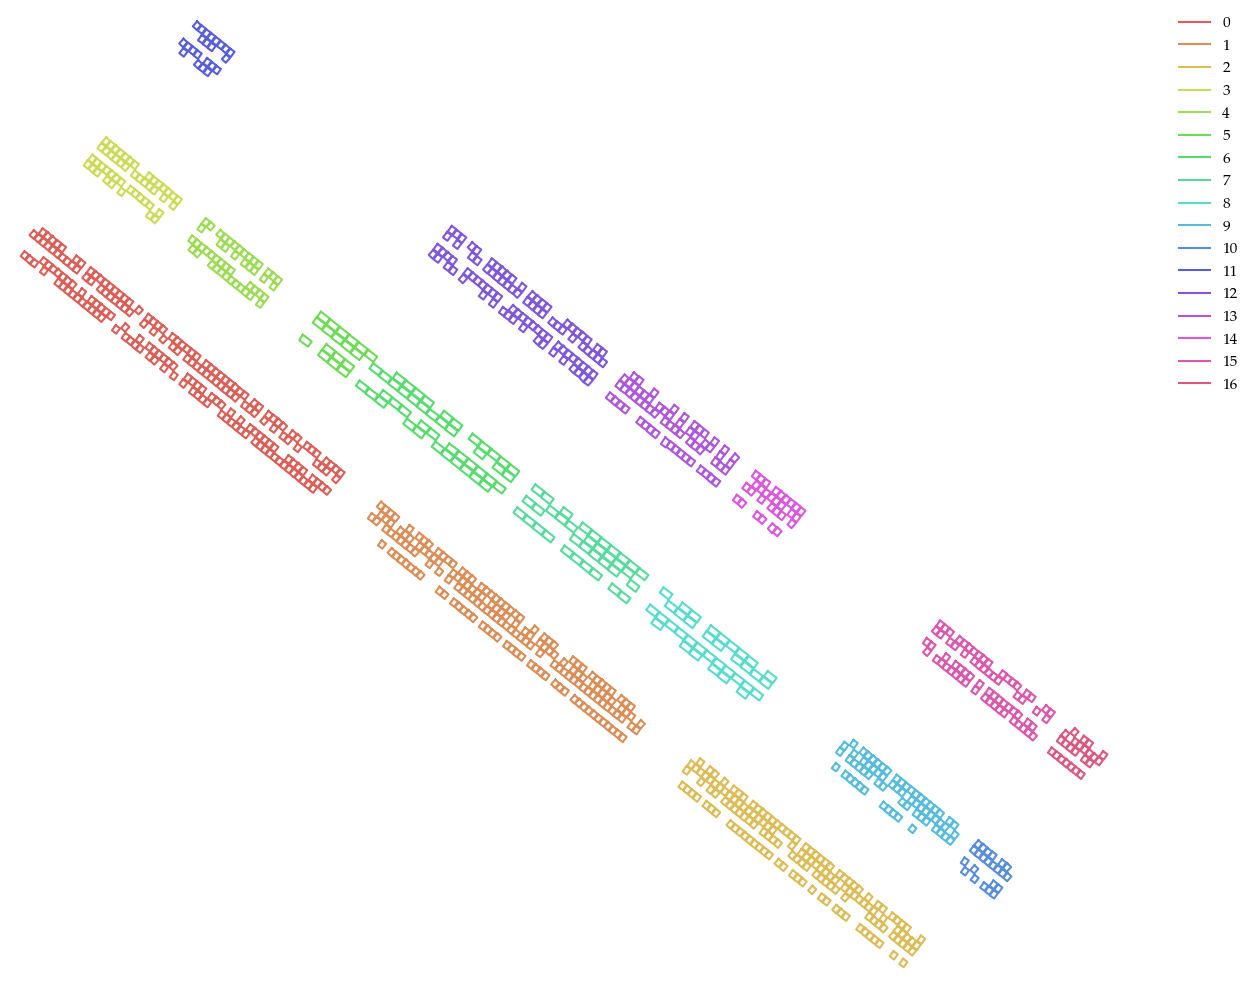

In [489]:
new_label_order = determine_row_col(cluster_centroid)

# Map new labels to old labels
idx = 0
new_labels_panel = labels.copy()
for cluster_indices in new_label_order:
    for idx2 in cluster_indices:
        new_labels_panel[labels == idx2] = idx
        idx += 1

plot_panels(shp, new_labels_panel, draw_text=False, savefig='results/array_map.png')

In [490]:
# Sum number of cells per panel
panel_count = np.zeros(len(np.unique(new_labels_panel)))
for (idx, elem) in enumerate(shp):
    panel_count[new_labels_panel[idx]] += 1

# Create vector similar to new_labels_panel
panel_count_vector = np.zeros(len(new_labels_panel), dtype=int)
for (idx, elem) in enumerate(new_labels_panel):
    panel_count_vector[idx] = panel_count[elem]

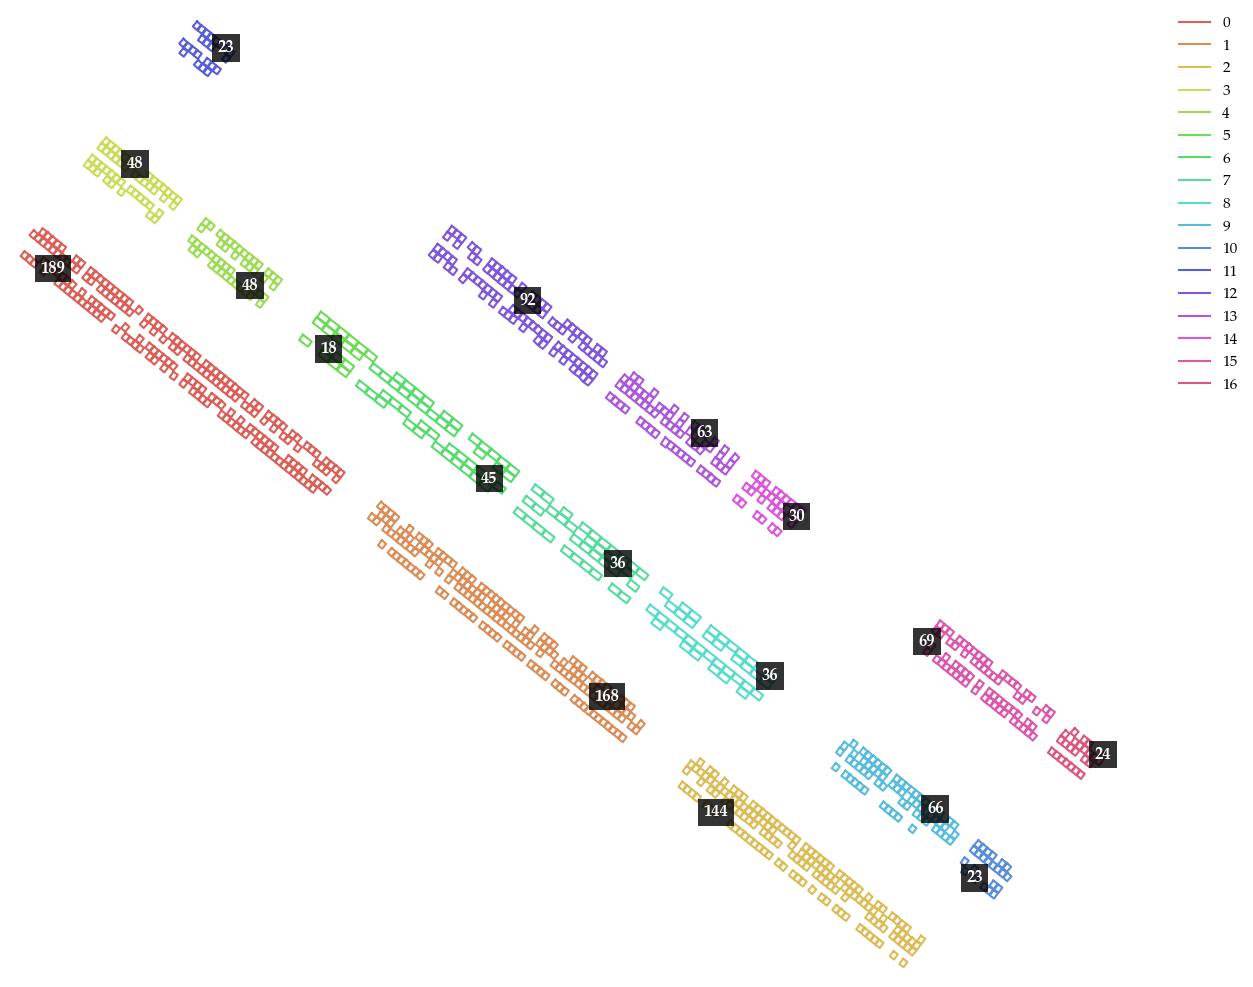

In [491]:
# Count number of cells per panel
plot_panels(shp, new_labels_panel, draw_text=True, text=panel_count_vector)

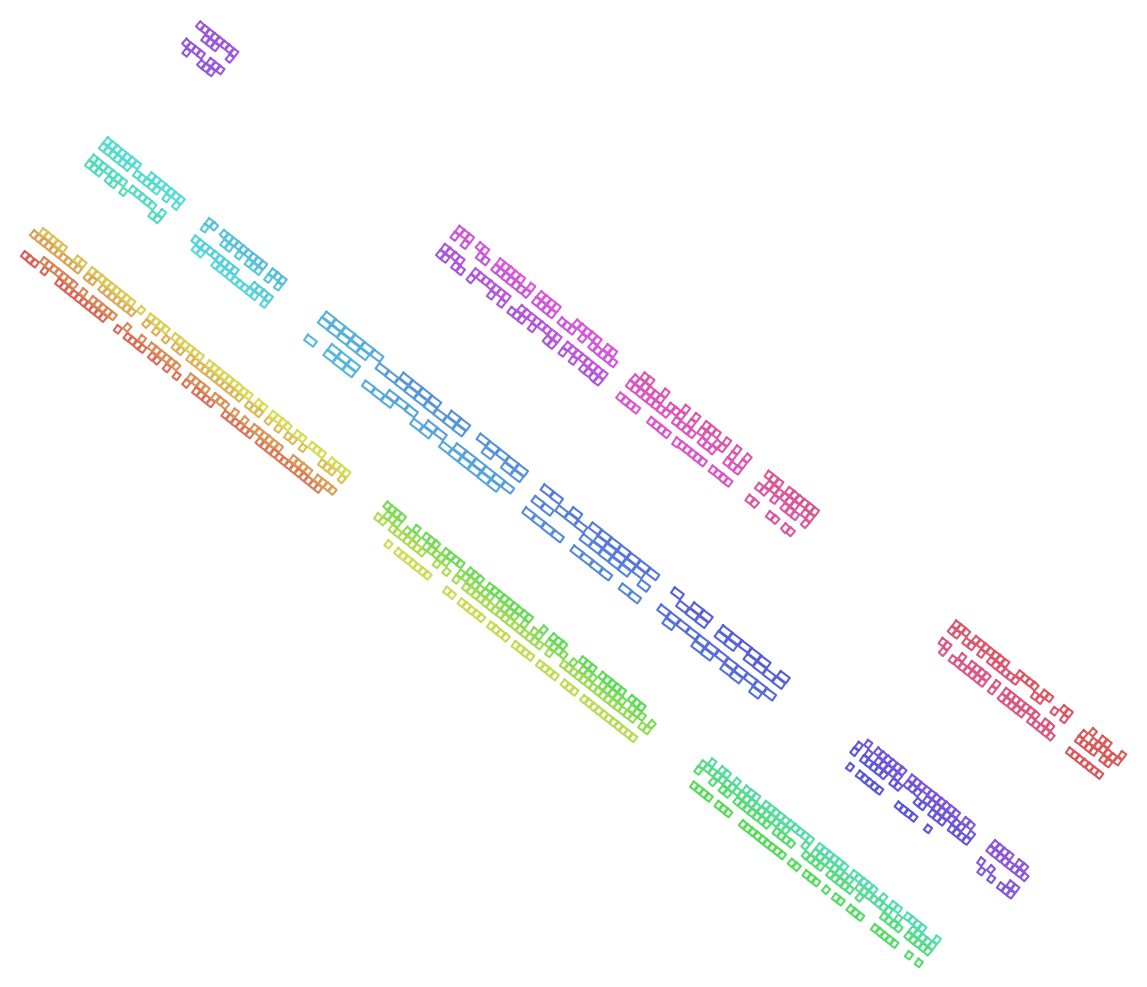

In [492]:
# Gather centroid by panel label
panel_centroid = [[] for i in range(len(np.unique(new_labels_panel)))]
panel_indices = [[] for i in range(len(np.unique(new_labels_panel)))]

# For each panel
for (idx, elem) in enumerate(shp):
    panel_centroid[new_labels_panel[idx]].append(rotated_centroid_table[idx])
    panel_indices[new_labels_panel[idx]].append(idx)

# Order by x-axis and y-axis
new_labels_cell = labels.copy()
row_indices = labels.copy()
col_indices = labels.copy()
idx = 0

for (panel_idx, panel_centroids) in enumerate(panel_centroid):
    new_label_order = determine_row_col(panel_centroids, max_vertical_distance=0.25)

    # Map new labels to old labels
    for (row_idx, panel_indices_row) in enumerate(new_label_order):
        for (col_idx, idx2) in enumerate(panel_indices_row):
            new_labels_cell[panel_indices[panel_idx][idx2]] = idx
            row_indices[panel_indices[panel_idx][idx2]] = row_idx
            col_indices[panel_indices[panel_idx][idx2]] = col_idx
            idx += 1

plot_panels(shp, new_labels_cell, draw_text=False, draw_legend=False, savefig='results/panel_map.png')

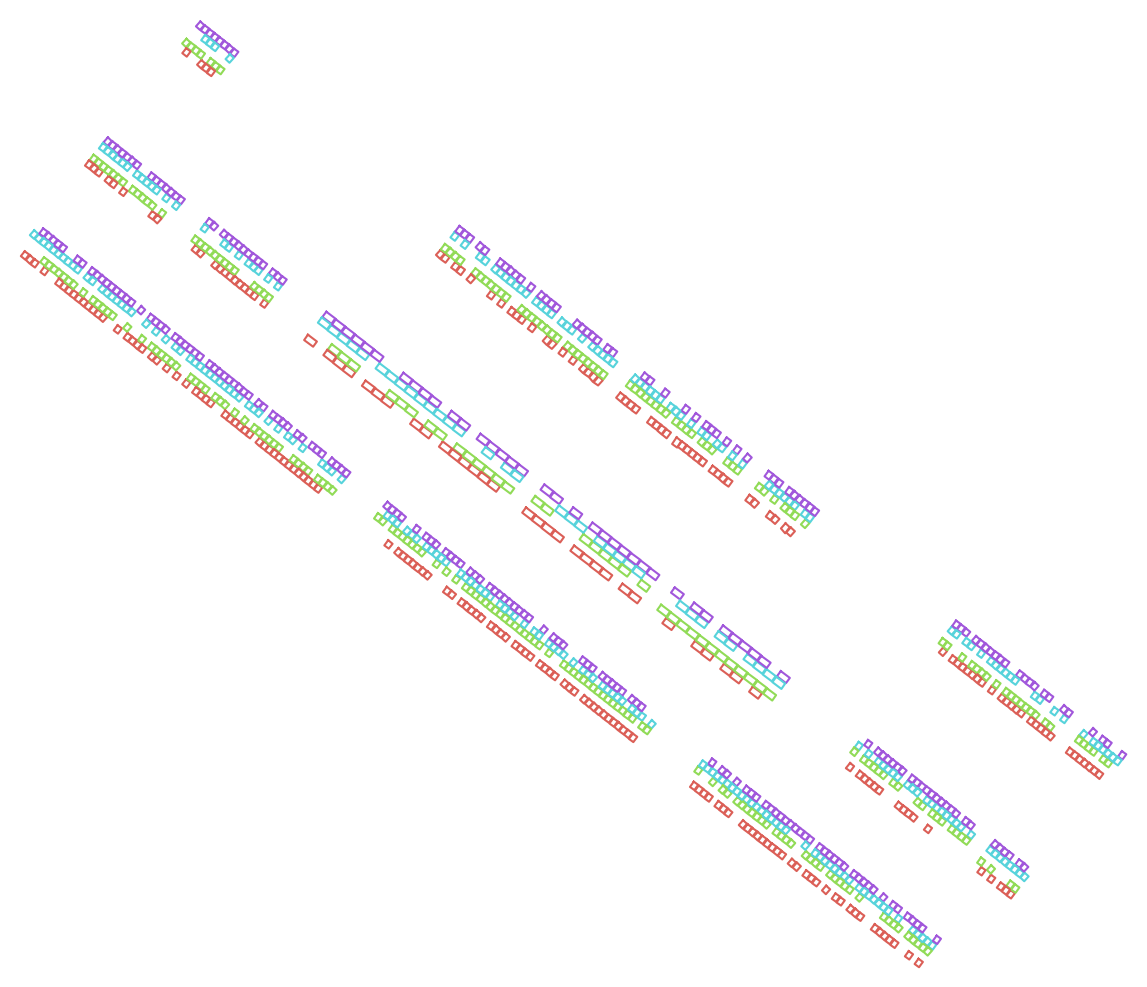

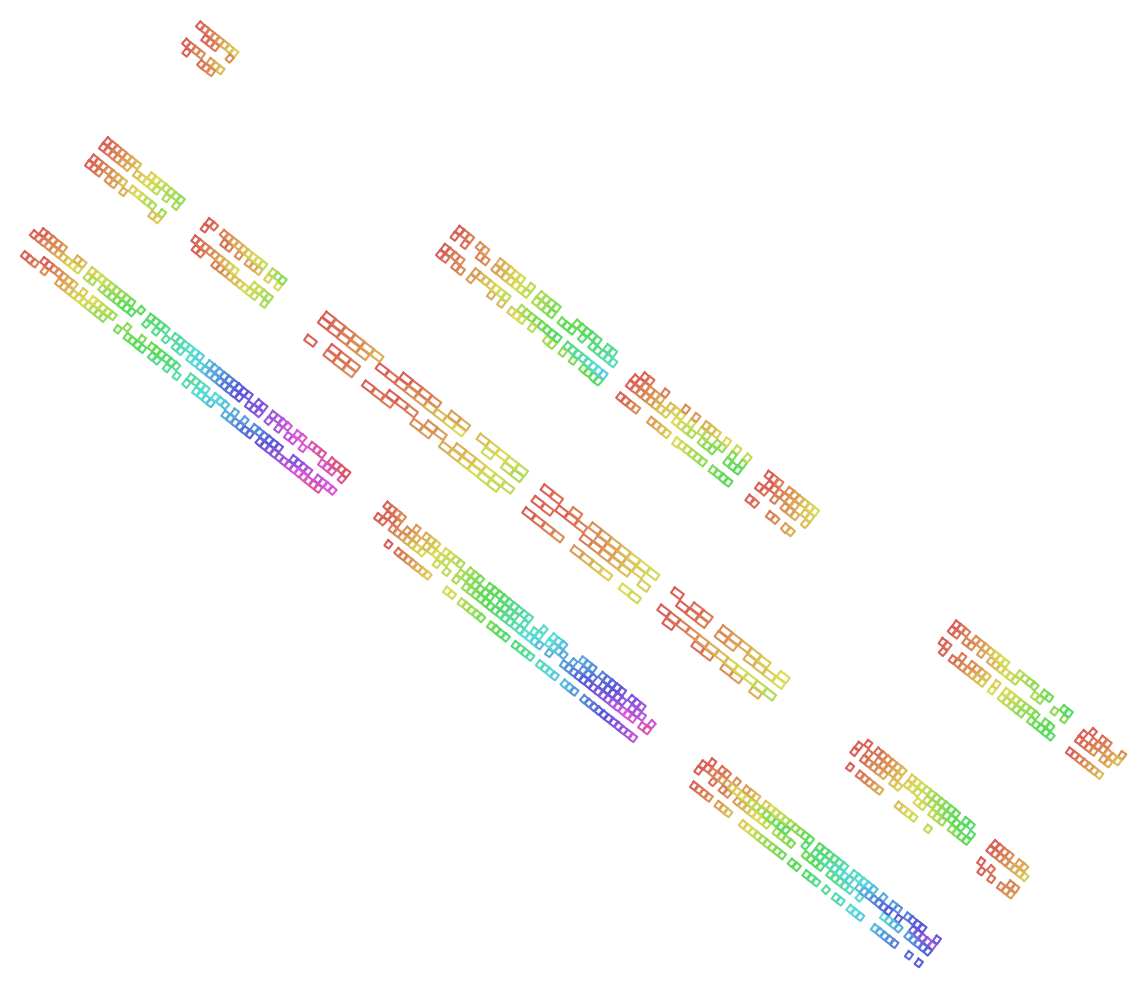

In [493]:
plot_panels(shp, row_indices, draw_text=False, draw_legend=False, savefig='results/row_map.png')
plot_panels(shp, col_indices, draw_text=False, draw_legend=False, savefig='results/col_map.png')

In [494]:
# Write back
schema = shp.schema.copy()
input_crs = shp.crs

# New attributes
schema['properties']['ID_ARRAY'] = 'int'
schema['properties']['ID_CELL'] = 'int'
schema['properties']['ID_ROW'] = 'int'
schema['properties']['ID_COL'] = 'int'

with fiona.open(filename.split('.')[0] + '_new.shp', 'w', 'ESRI Shapefile', schema, input_crs) as output:
    for (idx, elem) in enumerate(shp):
        elem['properties']['ID_ARRAY'] = int(new_labels_panel[idx])
        elem['properties']['ID_CELL'] = int(new_labels_cell[idx])
        elem['properties']['ID_ROW'] = int(row_indices[idx])
        elem['properties']['ID_COL'] = int(col_indices[idx])
        output.write({'properties': elem['properties'], 'geometry': elem['geometry']})

C:\Users\AlfonsoLópezRuiz\AppData\Local\Temp\ipykernel_14192\68001836.py:13: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  elem['properties']['ID_ARRAY'] = int(new_labels_panel[idx])
C:\Users\AlfonsoLópezRuiz\AppData\Local\Temp\ipykernel_14192\68001836.py:14: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  elem['properties']['ID_CELL'] = int(new_labels_cell[idx])
C:\Users\AlfonsoLópezRuiz\AppData\Local\Temp\ipykernel_14192\68001836.py:15: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  elem['properties']['ID_ROW'] = int(row_indices[idx])
C:\Users\AlfonsoLópezRuiz\AppData\Local\Temp\ipykernel_14192\68001836.py:16: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in f